In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import math
import scipy
from scipy.special import erf
import numpy
from numpy import exp
from numpy.lib.scimath import log, sqrt

In [2]:
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (13, 7)

In [24]:
def plotQuantities(s,t):
    dfPres=pd.read_fwf(r'./'+s+'PhaseData/output_pres.dat',header=None, infer_nrows=1001)
    dfPres.columns=['nBlocks','estimate','avg','err']
    dfTemp=pd.read_fwf(r'./'+s+'PhaseData/output_temp.dat',header=None, infer_nrows=1001)
    dfTemp.columns=['nBlocks','estimate','avg','err']
    dfKin=pd.read_fwf(r'./'+s+'PhaseData/output_ekin.dat',header=None, infer_nrows=1001)
    dfKin.columns=['nBlocks','estimate','avg','err']
    dfPot=pd.read_fwf(r'./'+s+'PhaseData/output_epot.dat',header=None, infer_nrows=1001)
    dfPot.columns=['nBlocks','estimate','avg','err']
    dfTot=pd.read_fwf(r'./'+s+'PhaseData/output_etot.dat',header=None, infer_nrows=1001)
    dfTot.columns=['nBlocks','estimate','avg','err']
    fig,axs=plt.subplots(2,1,constrained_layout = True)

    axs[0].errorbar(x=dfTemp.nBlocks, y=dfTemp.avg, yerr=dfTemp.err, label='average');
    axs[0].axhline(t,color='black',label='target temperature')
    axs[0].legend();
    axs[0].set_title("Cumulative mean of the temperature, "+s+" phase");
    axs[0].set_ylabel("T");
    axs[0].set_xlabel("number of blocks");
    axs[0].grid()
    axs[1].errorbar(x=dfPres.nBlocks, y=dfPres.avg, yerr=dfPres.err, label='average');
    axs[1].legend();
    axs[1].set_title("Cumulative mean of the pressure, "+s+" phase");
    axs[1].set_ylabel("p");
    axs[1].set_xlabel("number of blocks");
    axs[1].grid()
    plt.show()

    fig,axs=plt.subplots(2,1,constrained_layout = True)
    axs[0].errorbar(x=dfKin.nBlocks, y=dfKin.avg, yerr=dfKin.err, label='total energy');
    axs[0].legend();
    axs[0].set_title("Cumulative mean of the kinetic energy, "+s+" phase");
    axs[0].set_ylabel(r"$E_{kin}$");
    axs[0].set_xlabel("number of blocks");
    axs[0].grid()
    axs[1].errorbar(x=dfPot.nBlocks, y=dfPot.avg, yerr=dfPot.err, label='potential energy');
    axs[1].legend();
    axs[1].set_title("Cumulative mean of the potential energy, "+s+" phase");
    axs[1].set_ylabel(r"$E_{pot}$");
    axs[1].grid()
    axs[1].set_xlabel("number of blocks");

    fig,axs=plt.subplots(1,1,constrained_layout = True)
    axs.errorbar(x=dfTot.nBlocks, y=dfTot.avg, yerr=dfTot.err, label='total energy');
    axs.legend();
    axs.grid()
    axs.set_title("Cumulative mean of the total energy, "+s+" phase");
    axs.set_ylabel(r"$E_{tot}$");
    axs.set_xlabel("number of blocks");

In [13]:
def plotEquilibration(s):
    dfPot=pd.read_fwf(r'./equilibrationData/'+s+'/output_epot.dat',header=None, nrows_infer=100000)
    dfPot.columns=['nBlocks','estimate','avg','err']
    dfTot=pd.read_fwf(r'./equilibrationData/'+s+'/output_etot.dat',header=None, nrows_infer=100000)
    dfTot.columns=['nBlocks','estimate','avg','err']
    dfKin=pd.read_fwf(r'./equilibrationData/'+s+'/output_ekin.dat',header=None, nrows_infer=100000)
    dfKin.columns=['nBlocks','estimate','avg','err']
    
    dfPot.avg=dfPot.avg-dfPot.avg[len(dfPot.avg)-1]
    dfKin.avg=dfKin.avg-dfKin.avg[len(dfKin.avg)-1]
    dfTot.avg=dfTot.avg-dfTot.avg[len(dfTot.avg)-1]
    
    plt.errorbar(x=dfPot.nBlocks[0::10], y=dfPot.avg[0::10], yerr=dfPot.err[0::10], label='Potential');
    plt.errorbar(x=dfTot.nBlocks[0::10], y=dfTot.avg[0::10], yerr=dfTot.err[0::10], label='Total');
    plt.errorbar(x=dfKin.nBlocks[0::10], y=dfKin.avg[0::10], yerr=dfKin.err[0::10], label='kinetic');
    plt.grid()
    plt.legend();
    plt.title("Fluctuations of total, potential and kinetic energy equilibration for "+s+" phase");
    plt.ylabel("fluctuations");
    plt.xlabel("number of blocks");
    plt.show();
    dfTot.head(10)

## Exercise 4.01 ##
In this exercise we are required to use a molecular dynamics simulation software to simulate the behaviour of atoms interacting via the Lennard-Jones potential. The Lennard-Jones potential is usually written as
$$V(r)=4\epsilon\left(\left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^6\right)$$
We decided to simulate three diferrent cases, distinguished by the enviromental conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)
The quantities are expressed in the units defined by the Lennard-Jones potential

To simulate the motion we use the Verlet algorithm, which is a symplectic integrator and guarantees the conservation of energy.

The first problem we encounter is that the temperature that we use as input parameter isn't the real temperature of the system: we start from a face-centered cubic configuration, and after some time the the potential energy could increase or decrease, with a subsequent decrease or increase of the kinetic energy(and the temperature): we are working in the microcanonical ensembles, the energy is fixed and all the states with the same total energy have the same probabilities. To choose a temperature we can simulate the system with different initial temperatures and see the relationship between the initial temperature and the equilibrium temperature.
By trial and error we manage to find the initial values that bring the system to a steady state: we start with $T=1.99$ for the liquid phase, $T=0.96$ for the gas phase and $T=1.545$ for the solid state.
The initial configuration is always a BCC lattice

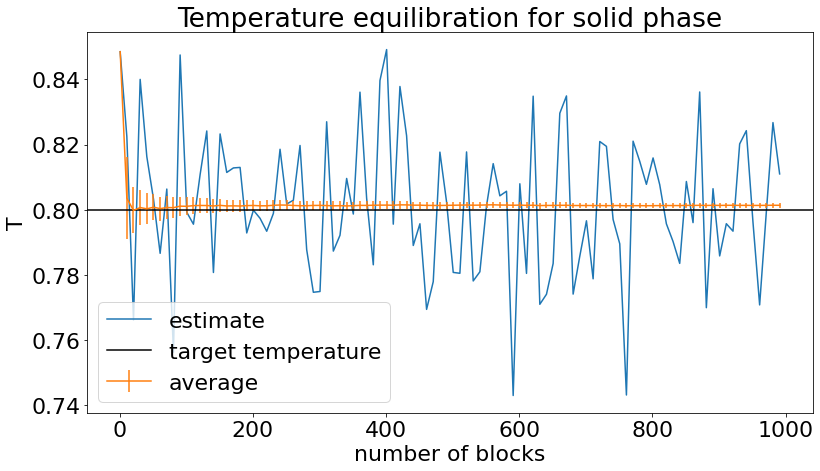

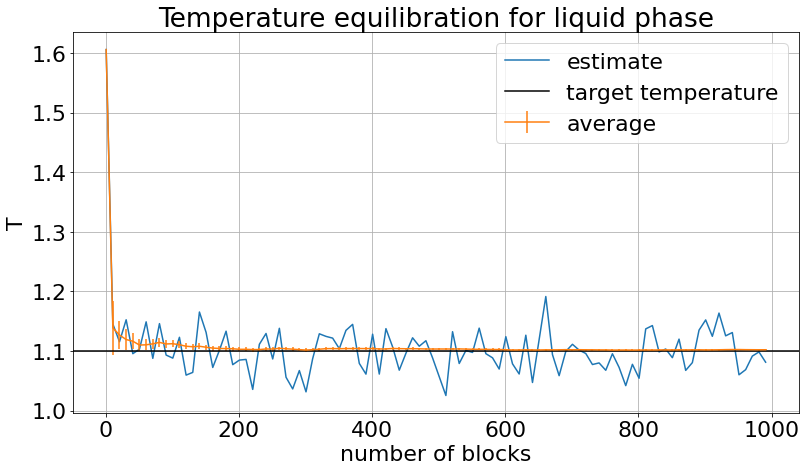

<function matplotlib.pyplot.show(close=None, block=None)>

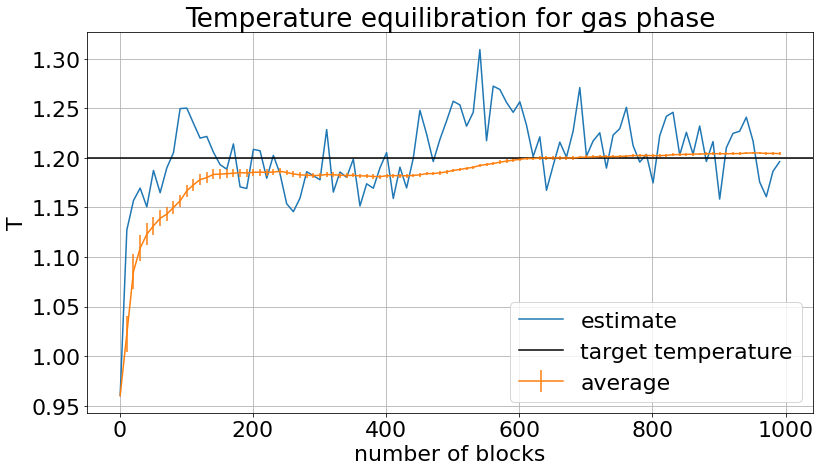

In [23]:
df1=pd.read_fwf(r'./equilibrationData/solid/output_temp.dat',header=None)
df1.columns=['nBlocks','estimate','avg','err']
df2=pd.read_fwf(r'./equilibrationData/liquid/output_temp.dat',header=None)
df2.columns=['nBlocks','estimate','avg','err']
df3=pd.read_fwf(r'./equilibrationData/gas/output_temp.dat',header=None, nrows_infer=100000)
df3.columns=['nBlocks','estimate','avg','err']

plt.plot(df1.nBlocks[0::10], df1.estimate[0::10], label='estimate');
plt.errorbar(x=df1.nBlocks[0::10], y=df1.avg[0::10], yerr=df1.err[0::10], label='average');
plt.axhline(0.8,color='black',label='target temperature')
plt.legend();
plt.title("Temperature equilibration for solid phase");
plt.ylabel("T");
plt.xlabel("number of blocks");
plt.show();

plt.plot(df2.nBlocks[0::10], df2.estimate[0::10], label='estimate');
plt.errorbar(x=df2.nBlocks[0::10], y=df2.avg[0::10], yerr=df2.err[0::10], label='average');
plt.axhline(1.1,color='black',label='target temperature')
plt.legend();
plt.title("Temperature equilibration for liquid phase");
plt.ylabel("T");
plt.xlabel("number of blocks");
plt.grid();
plt.show();

plt.plot(df3.nBlocks[0::10], df3.estimate[0::10], label='estimate');
plt.errorbar(x=df3.nBlocks[0::10], y=df3.avg[0::10], yerr=df3.err[0::10], label='average');
plt.axhline(1.2,color='black',label='target temperature')
plt.legend();
plt.title("Temperature equilibration for gas phase");
plt.ylabel("T");
plt.xlabel("number of blocks");
plt.grid();
plt.show

By watching the equilibration we can also gain some insight on the physics of the system. We always started from the 
crystalline phase

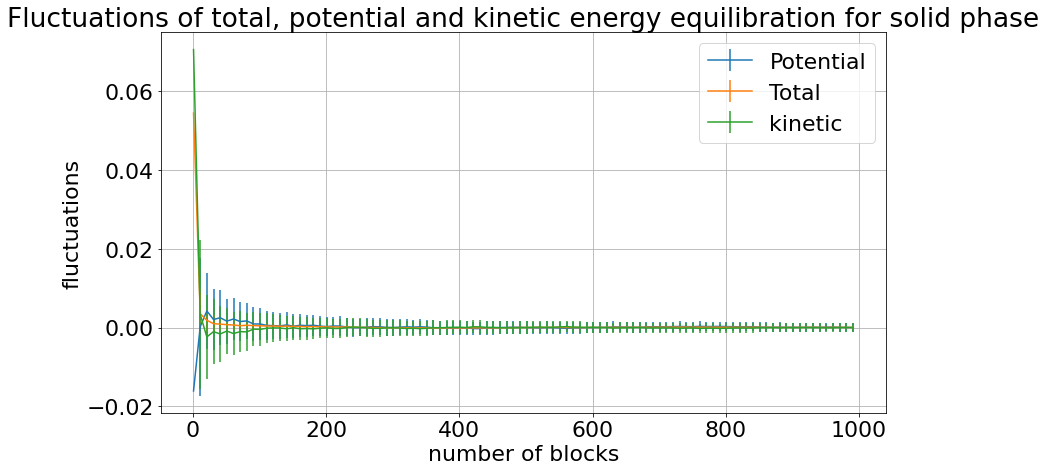

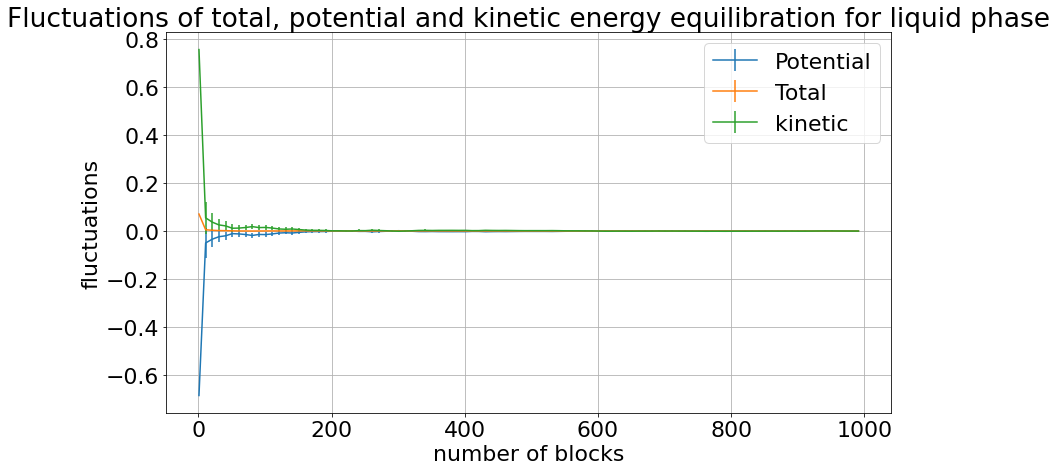

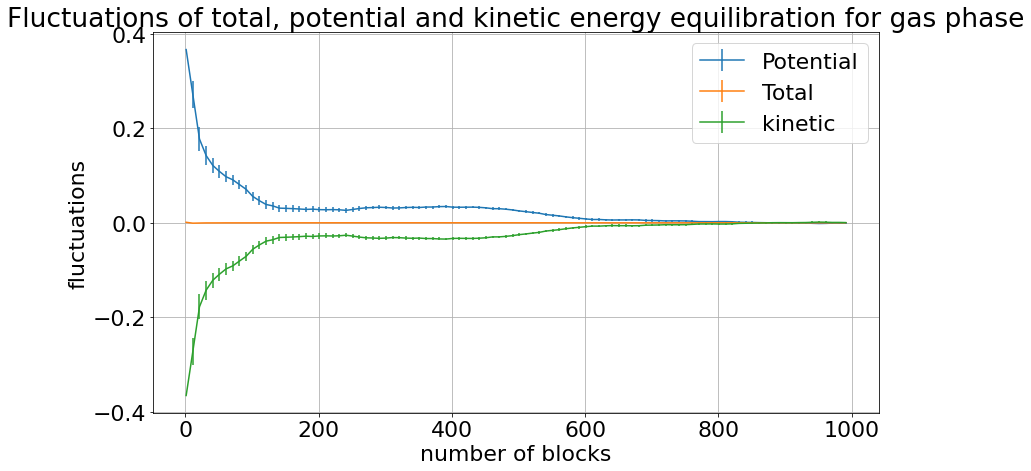

In [15]:
plotEquilibration('solid')
plotEquilibration('liquid')
plotEquilibration('gas')

We can see clearly what's going on: by setting the initial temperature we decided the initial distribution of the kinetic energies, but by starting from a BCC lattice we are in an unstable configuration. The two extreme cases are easy to understand: for a gas the lattice configuration is unstable and the potential energy slowly becomes kinetic energy, while for the solid we are already in a stable configuration, and the energy immediately becomes evenly distributed between the kinetic and the potential component. The liquid is the trickiest to understand, and probably we would need a more accurate analysis on the average interatomic distance to confront it with the equilibrium value to draw some grounded conclusions.

## Exercise 4.02 ##
We can now restart the simulations from the configurations we obtained after the equilibration to get the physical quantites we are looking for. The next plots are obtained by simulations with 100 blocks of 200 steps each

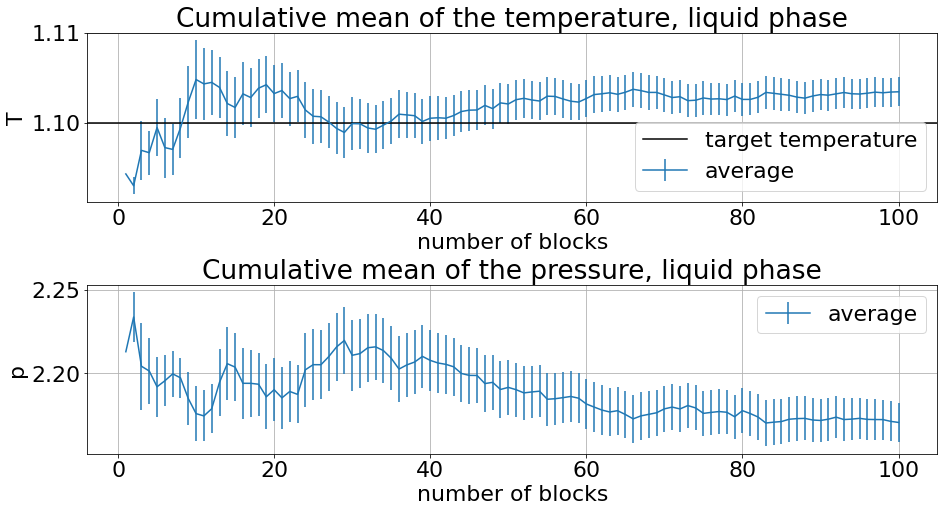

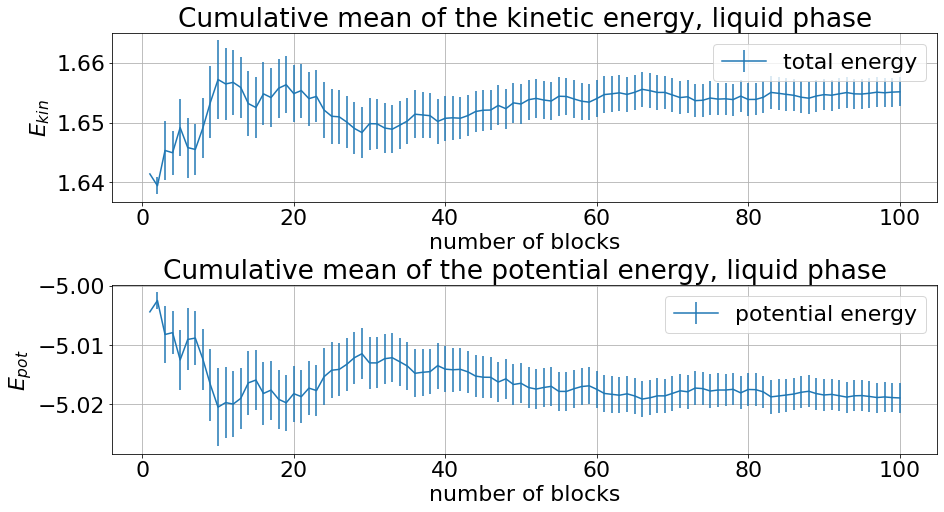

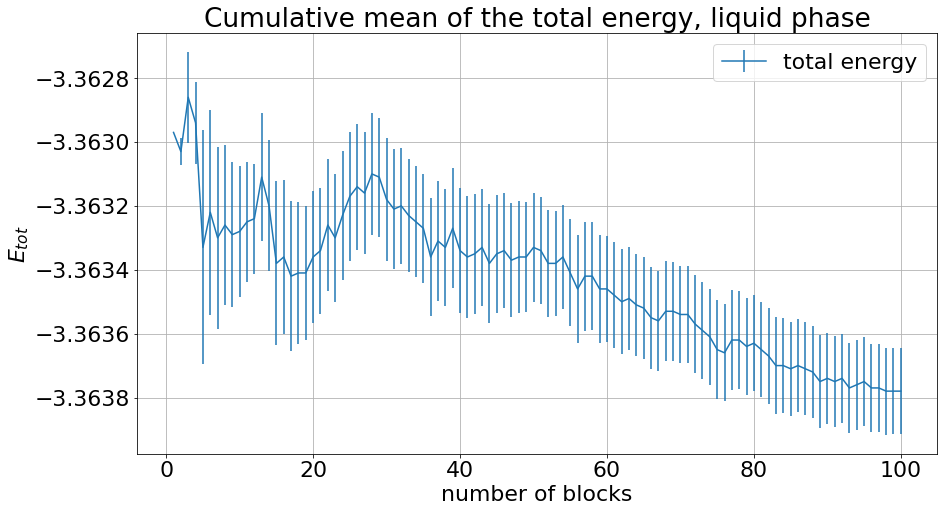

In [34]:
plotQuantities('liquid',1.1)

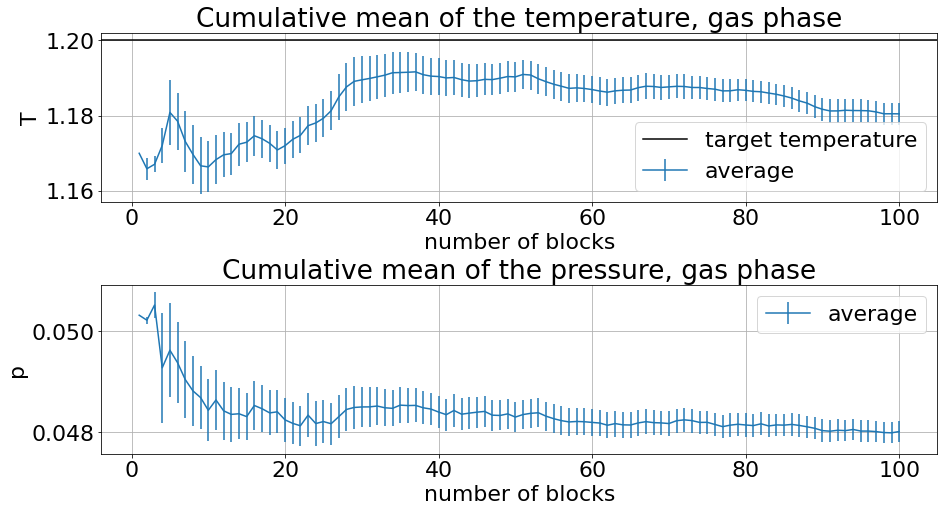

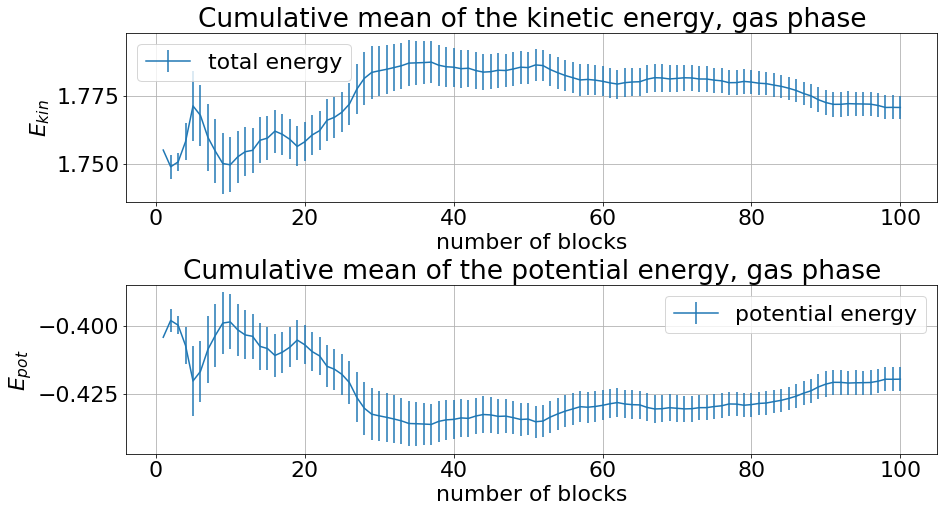

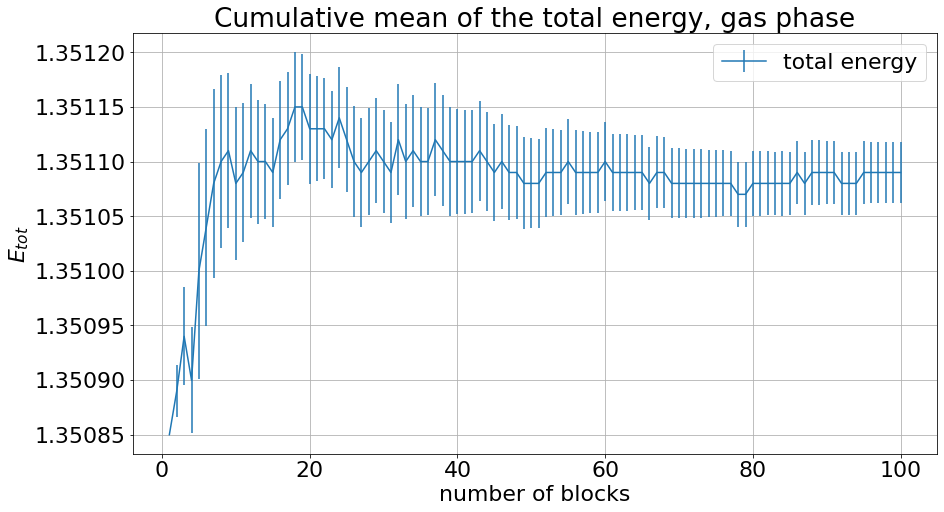

In [35]:
plotQuantities('gas',1.2)

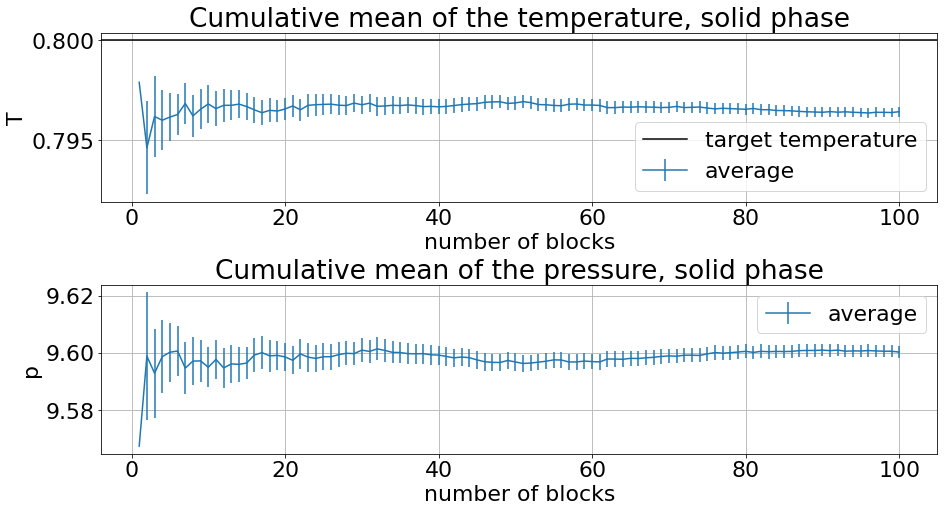

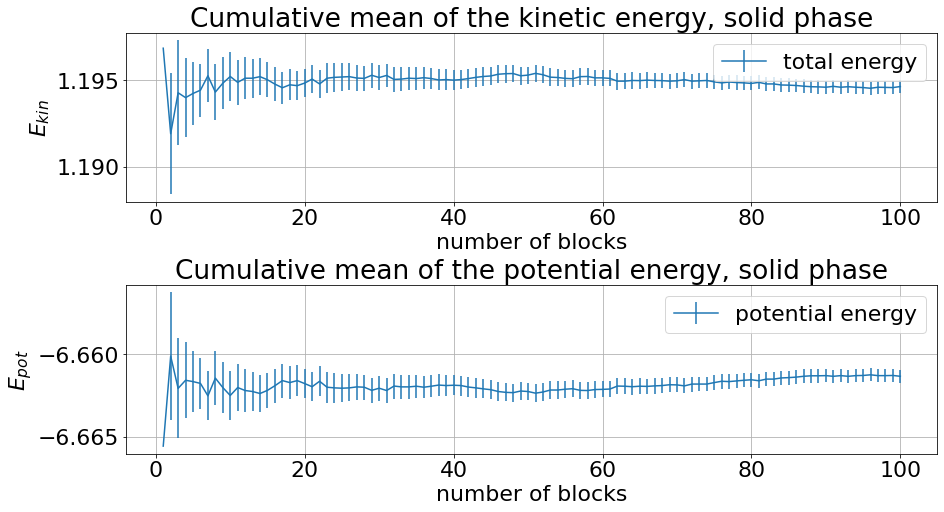

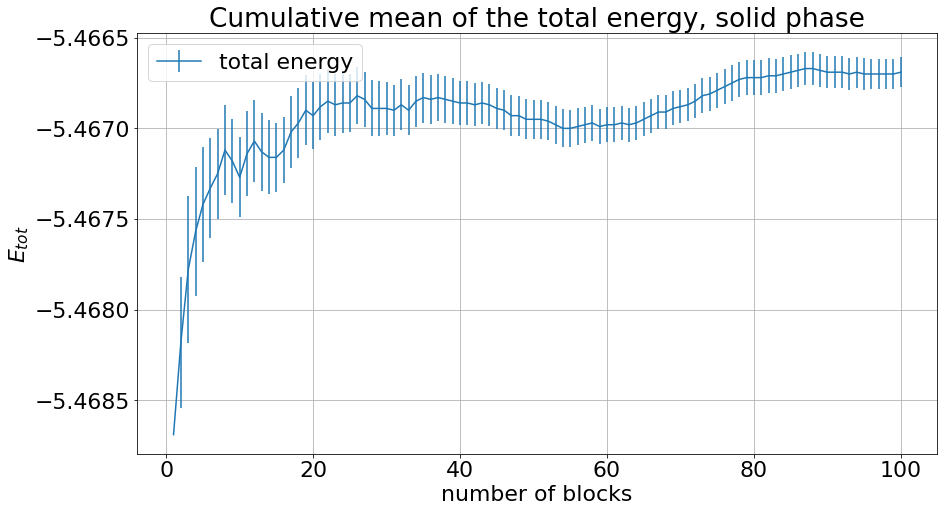

In [36]:
plotQuantities('solid',0.8)